In [ ]:
#With help of https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5

#TODO:

#Libs

In [335]:
from skimage import io,data,color,transform
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

#Functions

## generateGaussianKernel

In [336]:
def generateGaussianKernel(sigma=1,shape=None):
    if shape==None:    
        filter_size = 2 * int(4 * sigma + 0.5) + 1
        shape = (filter_size,filter_size)
    kernel = np.zeros(shape)
    m = shape[0]//2
    n = shape[0]//2
    for x in range(-m,m+1):
        for y in range(-n,n+1):
            kernel[x+m][y+n]= (1/(2*np.pi*sigma**2))*np.exp(-((x**2)+(y**2))/(2*sigma**2))
    return kernel*(1/np.sum(kernel))

## generateGaussianKernels

Computation of sigma if we convolve already convolved image.
$
\sigma =\sigma _1^{\:2}+\sigma _2^{\:2}
$


In [384]:
def generateSigmas(sigma, num_intervals):

    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = np.zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image,sigmas,numOctaves,kernel_size=None):

    gaussian_images = []
    for i in range(numOctaves):
        blured_images_in_octave = []
        for s in sigmas:
            image = signal.convolve2d(image, generateGaussianKernel(s,kernel_size), mode="same")
            blured_images_in_octave.append(image)
        gaussian_images.append(blured_images_in_octave)
        octave_base = blured_images_in_octave[-3]
        image = transform.resize(octave_base,(octave_base.shape[0]//2,octave_base.shape[1]//2))
    return gaussian_images

def generateBaseImage(image, sigma, assumed_blur):
    image = transform.resize(image,(image.shape[0]*2,image.shape[1]*2))
    return image;

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(np.log(min(image_shape)) / np.log(2) - 1))

## generateDOGs

In [338]:
def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(np.subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return np.array(dog_images)

In [389]:
img = color.rgb2gray(data.astronaut())
astr = generateBaseImage(img,1.6,0.5)
#numOctaves = computeNumberOfOctaves(astr.shape)
numOctaves = 3
num_intervals = 3
sigmas = generateSigmas(1.6,num_intervals)
GI = generateGaussianImages(astr,sigmas,numOctaves,(9,9))
DOG = generateDoGImages(GI)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


## findKeyPoints

#Visualizing Gaussian Pyramid

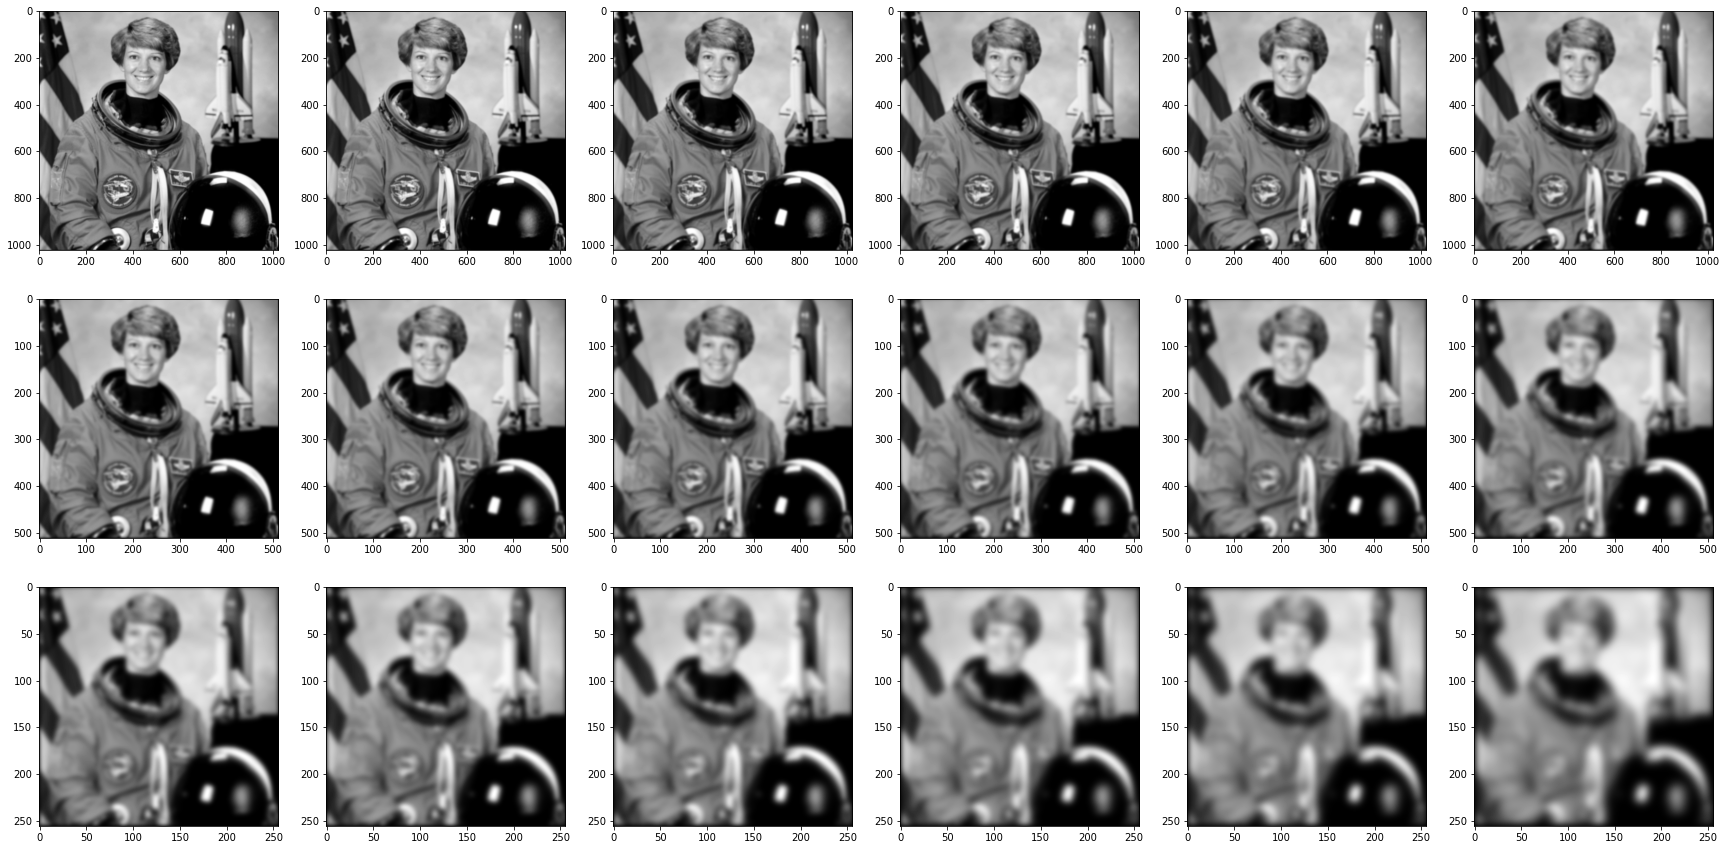

In [390]:
plt.figure(figsize=(30,15))

def displayPyramid(GI):
    dim1 = len(GI)
    #dim1 = 1
    dim2 = len(GI[0])
    im_num = 1
    for i in range(dim1):
        for j in range(dim2):
            plt.subplot(dim1,dim2,im_num)
            plt.imshow(GI[i][j],cmap="gray")
            im_num+=1
displayPyramid(GI)

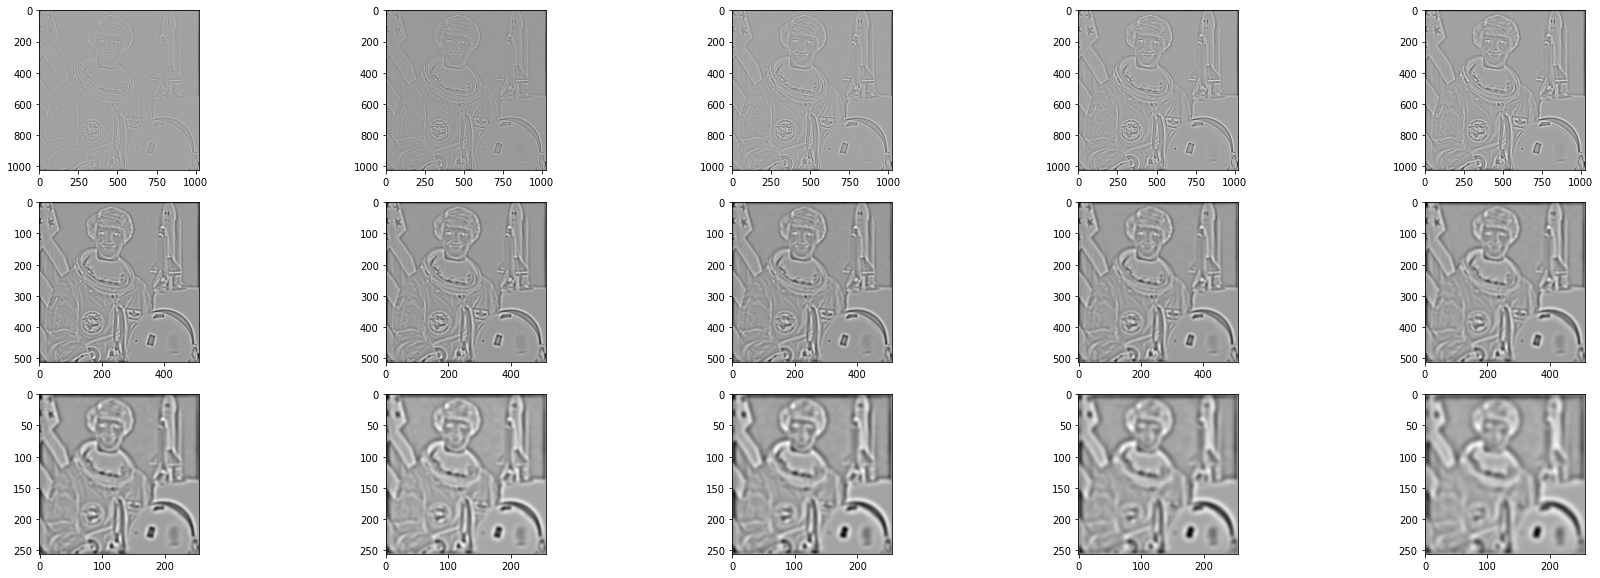

In [391]:
plt.figure(figsize=(30,10))
displayPyramid(DOG)

In [428]:
def isPixelExtremum(neighburs, threshold):
    center_point = neighburs[1,1,1]

    #if (center_point) > threshold:
    if True:
        maxPos = np.unravel_index(np.argmax(neighburs, axis=None), neighburs.shape)
        minPos = np.unravel_index(np.argmax(neighburs, axis=None), neighburs.shape)
        return  maxPos == (1,1,1) or minPos == (1,1,1)

    return False
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def findKeyPoints(DOG,num_intervals,contrast_threshold=0.04,image_border_width=5,display_one_iter=True):

    threshold = (0.5 * contrast_threshold / num_intervals)
    key_points = []
    for i_o, octave in enumerate(DOG):
        for index, (first_img,second_img,third_img) in enumerate(zip(octave,octave[1:],octave[2:])):
            for i in range(image_border_width,first_img.shape[0]-image_border_width):
                for j in range(image_border_width,first_img.shape[1]-image_border_width):
                    f = first_img [i-1:i+2,j-1:j+2]
                    s = second_img[i-1:i+2,j-1:j+2]
                    t = third_img [i-1:i+2,j-1:j+2]                     
                    if isPixelAnExtremum(f,s,t,threshold):
                        key_points.append((i,j,first_img.shape))
    return (key_points)

def keypoints_to_original_size(key_points,imsize):
    new_key_points = []
    for x,y,size in key_points:
        x = x + (imsize[0]-size[0])
        y = y + (imsize[0]-size[0])
        new_key_points.append((x,y))
    return new_key_points
                        
                          

5067


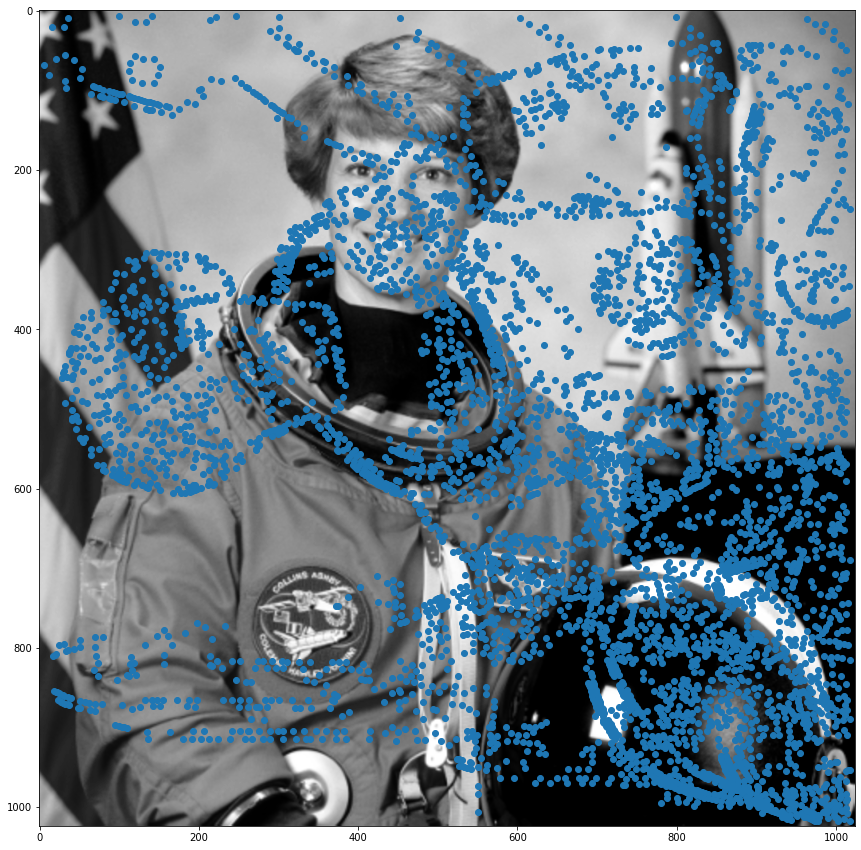

In [429]:
key_points=findKeyPoints(DOG,num_intervals)
key_points = keypoints_to_original_size(key_points,astr.shape)
print(len(key_points))
x,y = zip(*key_points)
plt.figure(figsize=(15,15))
plt.imshow(astr,cmap="gray")
plt.scatter(x,y)